In [1]:
import pandas as pd
import os
import xlrd
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [170]:
def plot_comparison_maps(df, col1, col2, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize  = (15, 12))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    df.plot(column = col1, 
            ax = ax[0], 
            figsize = (10, 10))
    ax[0].set_title(title1)

    df.plot(column = col2, 
            ax = ax[1], 
            figsize = (10, 10),
             legend=True,
            legend_kwds={'orientation': "vertical"},
            cax = cax)
    ax[1].set_title(title2)

## EV Charging Station Data

In [7]:
data_dir = '/Users/saraprice/Documents/NYU/Research/EV_Charging_Stations/Data'
os.chdir(data_dir)

In [58]:
EV_df = pd.read_excel('alt_fuel_stations_20200523.xls')
EV_df['zip_code'] = EV_df['ZIP'].astype(str).apply(lambda x:str.zfill(x, 5))
zip_df = pd.read_csv('other_cities_zip_codes.csv')
zip_df['zip_code']= zip_df['zip_code'].astype(str).apply(lambda x:str.zfill(x, 5))

### Limit to electric charging stations

In [50]:
EV_df = EV_df[EV_df['Fuel Type Code']=='ELEC']
EV_df.shape

(42501, 65)

In [73]:
city_states = {'San Jose': 'CA',
               'San Francisco': 'CA',
               'Los Angeles': 'CA',
               'Seattle': 'WA',
               'Austin': 'TX',
               'Boston': 'MA',
               'Hartford': 'CT',
               'Phoenix': 'AZ',
                'Portland': 'OR', 
               'Austin': 'TX', 
               'Denver': 'CO', 
               'Washington': 'DC'}

#### save into separate city dataframe

In [123]:
cities = ['San Jose', 'Los Angeles', 'San Francisco', 'Seattle', 'Portland', 'Austin', 'Boston', 'Denver', 'Hartford',
          'Phoenix', 'Washington']

EV_cities = {}
for city in cities:
    EV_df[f'{city}_ind'] = EV_df["City"].apply(lambda x: str.find(x, city))
    EV_cities[city] = EV_df[EV_df[f'{city}_ind']>= 0]
    if city in list(city_states.keys()):
        EV_cities[city] = EV_cities[city][EV_cities[city]['State']==city_states[city]]
    print(city)
    print(EV_cities[city].shape)
EV_other_cities = pd.concat([EV_cities[city] for city in cities], axis= 0)
print(EV_other_cities.shape)

San Jose
(514, 76)
Los Angeles
(1301, 76)
San Francisco
(642, 76)
Seattle
(339, 76)
Portland
(181, 76)
Austin
(508, 76)
Boston
(292, 76)
Denver
(260, 76)
Hartford
(49, 76)
Phoenix
(222, 76)
Washington
(237, 76)
(4545, 76)


In [125]:
EV_other_cities.rename(columns = {'Station Name': 'station_name'}, inplace = True)

In [126]:
#Limit to only necessary columns
EV_other_cities = EV_other_cities[['station_name', 'zip_code']]
EV_other_cities = EV_other_cities.groupby('zip_code').count().reset_index()
EV_other_cities.rename(columns={'station_name': 'station_count'}, inplace = True)
EV_other_cities['station_present'] = np.where(EV_other_cities['station_count']> 0, 1, 0)

In [127]:
EV_other_cities.sort_values('zip_code')

,zip_code,station_count,station_present
0,02108,4,1
1,02109,9,1
2,02110,35,1
3,02111,6,1
4,02114,19,1
...,...,...,...
392,98188,7,1
393,98191,1,1
394,98195,4,1
395,98199,1,1


In [128]:
## Combine zip codes and EV data
print(zip_df.shape)
print(EV_other_cities.shape)
EV_other_zips = pd.merge(zip_df, EV_other_cities, on = 'zip_code', how = 'left')
print(EV_other_zips.shape)
EV_other_zips.head()
for city in cities:
    print(city)
    print(len(EV_other_zips[EV_other_zips.city == city]))

(930, 2)
(397, 3)
(930, 4)
San Jose
59
Los Angeles
98
San Francisco
51
Seattle
60
Portland
60
Austin
74
Boston
51
Denver
71
Hartford
51
Phoenix
75
Washington
280


In [130]:
EV_other_zips[(EV_other_zips.city == 'Hartford') & (EV_other_zips.station_count> 0)]

,city,zip_code,station_count,station_present
53,Hartford,06103,16.0,1.0
55,Hartford,06105,1.0,1.0
56,Hartford,06106,10.0,1.0
57,Hartford,06107,4.0,1.0
58,Hartford,06108,3.0,1.0
60,Hartford,06110,4.0,1.0
63,Hartford,06114,1.0,1.0
65,Hartford,06117,1.0,1.0
66,Hartford,06118,2.0,1.0
68,Hartford,06120,5.0,1.0


## Demo Data

In [158]:
demo_col_dict = {'median_income': ['Estimate!!Median income (dollars)!!FAMILIES!!Families'],
                'poverty' : ['Estimate!!Percent below poverty level!!Population for whom poverty status is determined'],
                'demo': ['Percent!!RACE!!Total population!!One race!!White',
                         'Percent!!RACE!!Total population!!One race!!Black or African American',
                         'Percent!!RACE!!Total population!!One race!!Asian',
                         'Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)',
                        'Percent!!RACE!!Total population!!One race!!American Indian and Alaska Native']
                }
rename_col_dict = {'Estimate!!Median income (dollars)!!FAMILIES!!Families': 'median_income',
                   'Estimate!!Percent below poverty level!!Population for whom poverty status is determined' : 'poverty_rate',
                   'Percent!!RACE!!Total population!!One race!!White': 'white_perc',
                   'Percent!!RACE!!Total population!!One race!!Black or African American' : 'black_perc',
                   'Percent!!RACE!!Total population!!One race!!Asian' : 'asian_perc',
                   'Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)' : 'hispanic_perc',
                   'Percent!!RACE!!Total population!!One race!!American Indian and Alaska Native' : 'native_american_perc'
                }

In [159]:
demo_list = ['median_income', 'poverty', 'demo']
temp_df = {}
demo_df = {}
for city in cities:
    temp_df[city] = {}
    for d in demo_list:
        temp_df[city][d] = pd.read_csv('ACS/{}_ACS_5yr_{}_data_full.csv'.format(city_states[city], d), header = 1)
        keep_cols = ['Geographic Area Name'] + demo_col_dict[d]
        temp_df[city][d] = temp_df[city][d][keep_cols]
        temp_df[city][d]['zip_code'] = temp_df[city][d]['Geographic Area Name'].apply(lambda x: x[-5:])
        temp_df[city][d].drop('Geographic Area Name', inplace = True,axis =1)
        if d == 'median_income':
            demo_df[city] = temp_df[city][d]
        else:
            demo_df[city] = pd.merge(demo_df[city], temp_df[city][d], on = 'zip_code')
    demo_df[city].rename(columns = rename_col_dict, inplace = True)   
    for col in list(rename_col_dict.values()):
        demo_df[city][col] = np.where(demo_df[city][col]=='250,000+', 250000,
                                      np.where(demo_df[city][col]=='2,500-', 2500,
                                      np.where(demo_df[city][col].isin(['-', 'nan']), 0,
                                               demo_df[city][col])))
        demo_df[city][col] = demo_df[city][col].astype(float)
    if city == 'San Jose':
        print(demo_df[city].dtypes)
        print(demo_df[city].head())

median_income           float64
zip_code                 object
poverty_rate            float64
white_perc              float64
black_perc              float64
asian_perc              float64
hispanic_perc           float64
native_american_perc    float64
dtype: object
   median_income zip_code  poverty_rate  white_perc  black_perc  asian_perc  \
0        45360.0    90001          25.6        41.9         8.9         0.3   
1        40222.0    90002          31.4        43.0        18.9         1.0   
2        42333.0    90003          30.1        33.1        20.7         0.3   
3        51104.0    90004          17.8        35.7         3.6        25.5   
4        44586.0    90005          26.1        23.3         5.8        34.2   

   hispanic_perc  native_american_perc  
0           90.1                   0.8  
1           78.9                   1.5  
2           78.3                   0.7  
3           50.3                   0.2  
4           49.5                   0.5  


### Merge demo data with EV charging data

In [169]:
EV_demo = {}
for city in cities:
    EV_temp = EV_other_zips[EV_other_zips['city']==city]
    EV_demo[city] = pd.merge(EV_temp, demo_df[city], on = 'zip_code', how = 'left')
    EV_demo[city]['station_present'] = EV_demo[city]['station_present'].fillna(0)

## Analysis

### Correlation

In [168]:
for city in cities:
    corr_df = EV_demo[city].corr()[['station_present', 'station_count']]
    corr_df = corr_df[(corr_df.index != 'station_count') & (corr_df.index != 'station_present')]
    corr_df.sort_values('station_present', ascending = False)
    print(city)
    print(corr_df)

San Jose
                      station_present  station_count
median_income                0.060711      -0.129712
poverty_rate                 0.148589       0.384218
white_perc                  -0.340622      -0.025978
black_perc                  -0.159730       0.428560
asian_perc                   0.290691      -0.113897
hispanic_perc                0.052860       0.065936
native_american_perc         0.170442      -0.018645
Los Angeles
                      station_present  station_count
median_income                0.245246       0.088386
poverty_rate                -0.058888       0.031635
white_perc                   0.034936       0.160257
black_perc                   0.067629      -0.108183
asian_perc                   0.271620       0.234827
hispanic_perc                0.013651      -0.261178
native_american_perc         0.083504      -0.152908
San Francisco
                      station_present  station_count
median_income               -0.021618      -0.313519
poverty_rat

In [200]:
zip_col_dict = {'San Jose': 'ZIPCODE',
               'San Francisco': 'ZIP',
               'Los Angeles': 'ZIPCODE',
               'Seattle': 'ZIPCODE',
               'Austin': 'zipcode',
               'Boston': 'ZIP5',
               'Hartford': 'zcta5ce10',
               'Phoenix': 'ZIP_CODE',
                'Portland': 'ZIPCODE', 
               'Denver': 'ZCTA5CE10', 
               'Washington': 'ZIPCODE'}

In [223]:
### Load zip code boundaries
zip_boundaries = {}

for city in cities:
    zip_boundaries[city] = gpd.read_file(f'zip_code_boundaries/zip_code_boundary_{city}/Zip_Code_Boundary.dbf')
    zip_boundaries[city]['zip_code'] = zip_boundaries[city][zip_col_dict[city]].astype(str).apply(lambda x: str.zfill(x, 5))
    zip_boundaries[city] = zip_boundaries[city][['zip_code', 'geometry']]
    if city == 'Phoenix':
        print(zip_boundaries[city].shape)
        zip_boundaries[city].dropna(axis = 0, inplace = True)
        print(zip_boundaries[city].shape)
        zip_boundaries[city] = zip_boundaries[city].dissolve('zip_code')
        print(zip_boundaries[city].shape)

(499411, 2)
(499410, 2)
(91472, 1)


In [221]:
EV_demo_geo = {}
for city in cities:
    print(city)
    print(EV_demo[city].shape)
    print(zip_boundaries[city].drop_duplicates().shape)
    EV_demo_geo[city] = pd.merge(EV_demo[city], zip_boundaries[city], on = ['zip_code'], how = 'left')
    EV_demo_geo[city] = gpd.GeoDataFrame(EV_demo_geo[city], geometry = EV_demo_geo[city].geometry)
    EV_demo_geo[city].dropna(axis = 0,inplace = True)
    print(EV_demo_geo[city].shape)
    EV_demo_geo[city] = EV_demo_geo[city].dissolve(by = 'zip_code')
    print(EV_demo_geo[city].shape)

San Jose
(59, 11)
(66, 2)
(26, 12)
(26, 11)
Los Angeles
(98, 11)
(311, 2)
(62, 12)
(62, 11)
San Francisco
(51, 11)
(187, 2)
(23, 12)
(23, 11)
Seattle
(60, 11)
(204, 2)
(29, 12)
(29, 11)
Portland
(60, 11)
(142, 2)
(32, 12)
(32, 11)
Austin
(74, 11)
(80, 2)
(39, 12)
(39, 11)
Boston
(51, 11)
(43, 2)
(22, 12)
(22, 11)
Denver
(71, 11)
(526, 2)
(33, 12)
(33, 11)
Hartford
(51, 11)
(282, 2)
(10, 12)
(10, 11)
Phoenix
(75, 11)


Exception ignored in: <function BaseGeometry.__del__ at 0x7fa6d206f820>
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/shapely/geometry/base.py", line 242, in __del__
    self.empty(val=None)
  File "/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/shapely/geometry/base.py", line 227, in empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 


(499105, 2)
(45000, 12)
(34, 11)
Washington
(280, 11)
(170, 2)
(24, 12)
(24, 11)


In [216]:
EV_demo_geo["Phoenix"]

,city,zip_code,station_count,station_present,median_income,poverty_rate,white_perc,black_perc,asian_perc,hispanic_perc,native_american_perc,geometry
0,Phoenix,85001,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((656242.355 887821.432, 656373.189 88..."
1,Phoenix,85002,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,Phoenix,85003,6.0,1.0,100357.0,19.5,79.2,9.0,1.5,32.0,2.8,"POLYGON ((649871.098 896637.821, 649936.047 89..."
3,Phoenix,85003,6.0,1.0,100357.0,19.5,79.2,9.0,1.5,32.0,2.8,"POLYGON ((649806.461 896638.001, 649871.098 89..."
4,Phoenix,85003,6.0,1.0,100357.0,19.5,79.2,9.0,1.5,32.0,2.8,"POLYGON ((650498.274 896476.487, 650499.867 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...
53746,Phoenix,85087,NaN,0.0,81467.0,7.1,90.9,0.7,3.5,6.2,0.5,"POLYGON ((628737.000 1050818.106, 628724.889 1..."
53747,Phoenix,85087,NaN,0.0,81467.0,7.1,90.9,0.7,3.5,6.2,0.5,"POLYGON ((629013.851 1050216.664, 628971.847 1..."
53748,Phoenix,85087,NaN,0.0,81467.0,7.1,90.9,0.7,3.5,6.2,0.5,"POLYGON ((628735.929 1050291.660, 628733.083 1..."
53749,Phoenix,85087,NaN,0.0,81467.0,7.1,90.9,0.7,3.5,6.2,0.5,"POLYGON ((628510.081 1048822.904, 629146.752 1..."


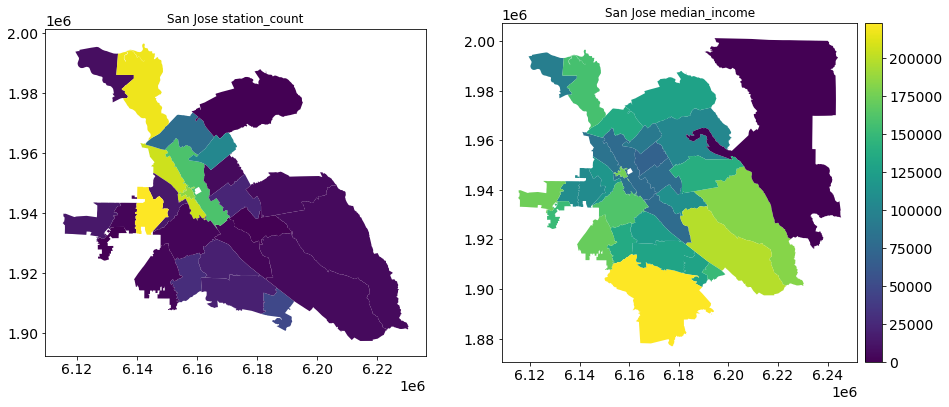

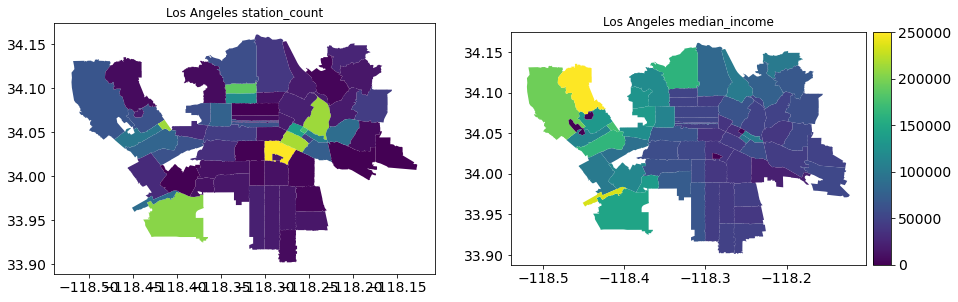

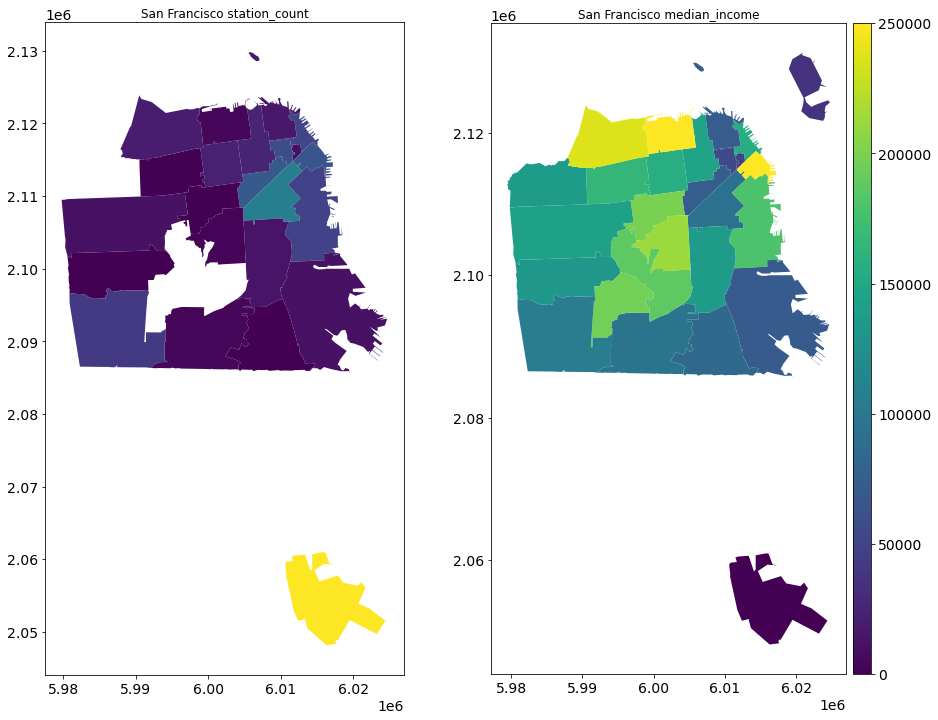

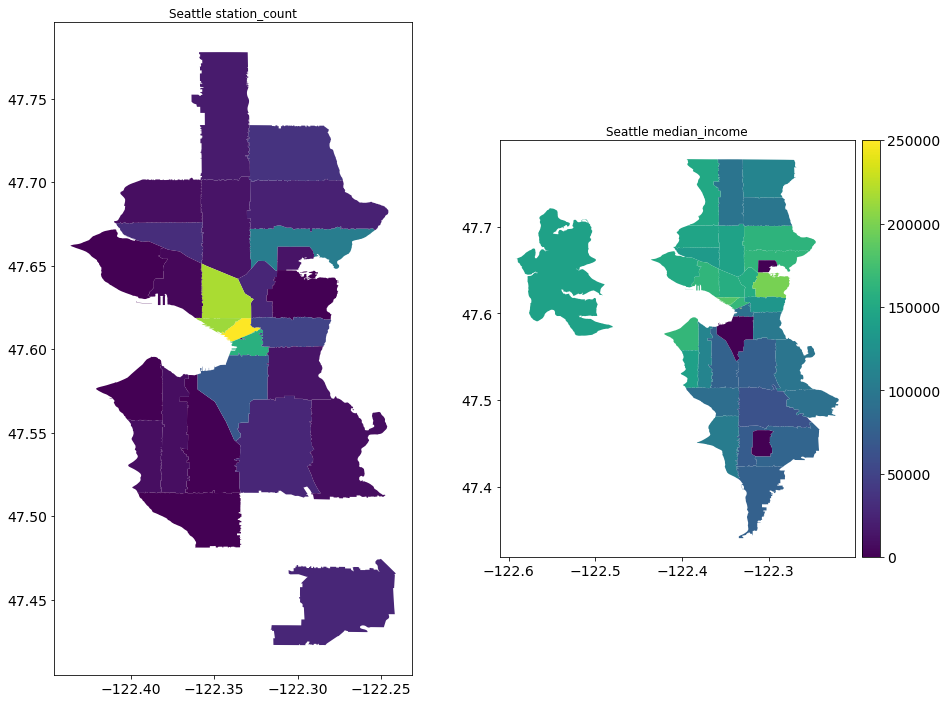

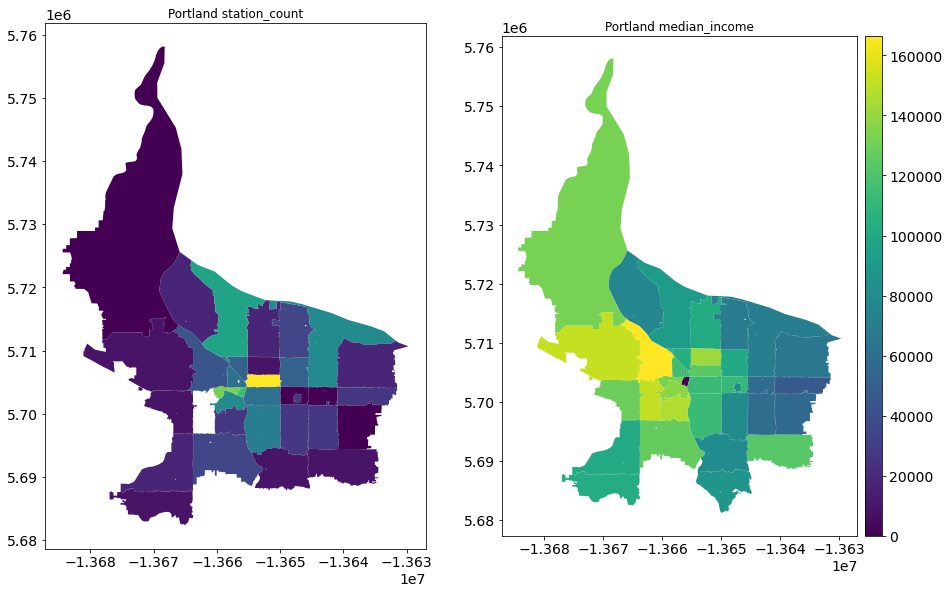

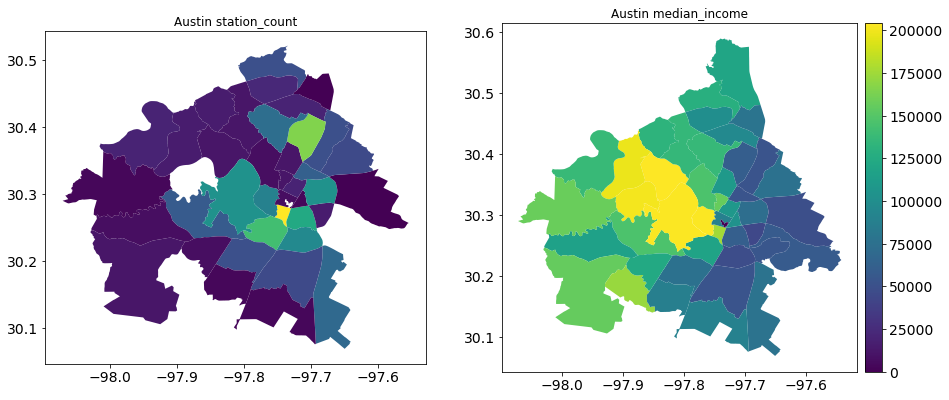

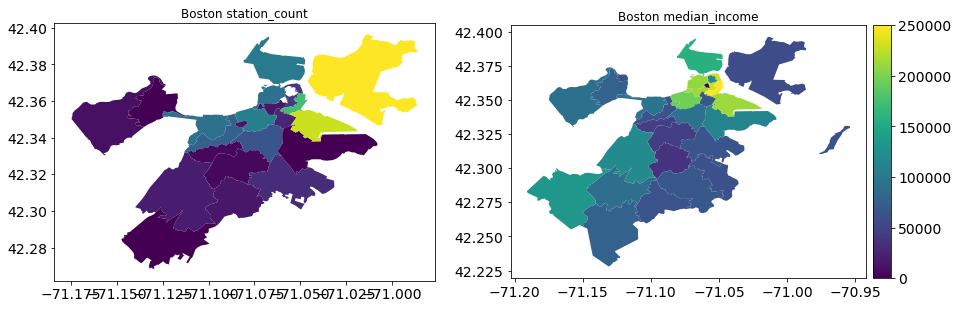

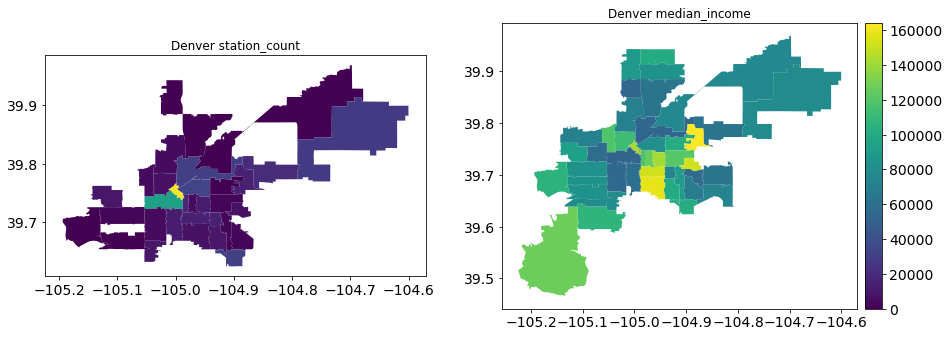

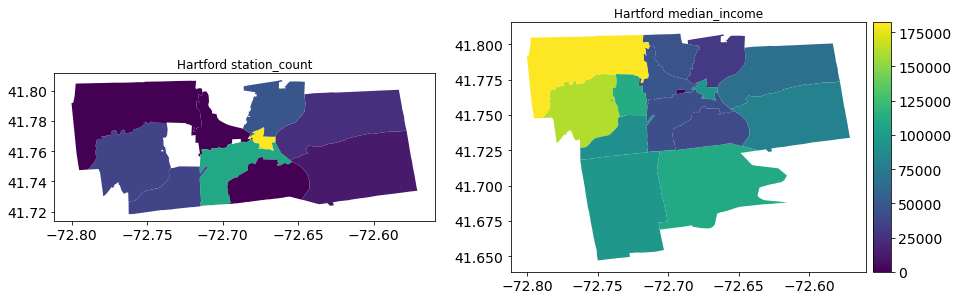

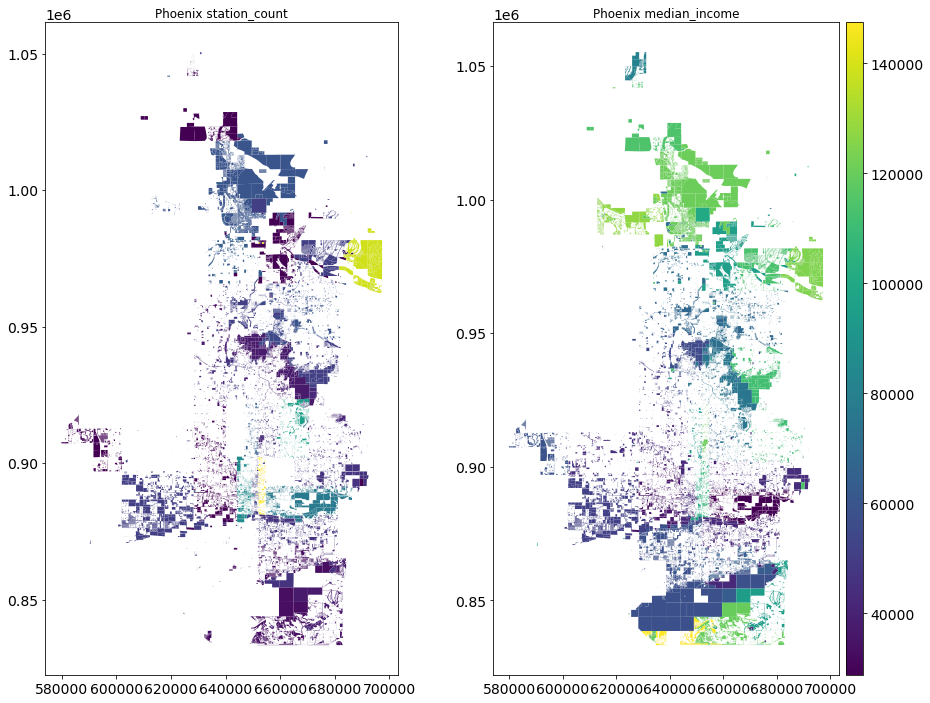

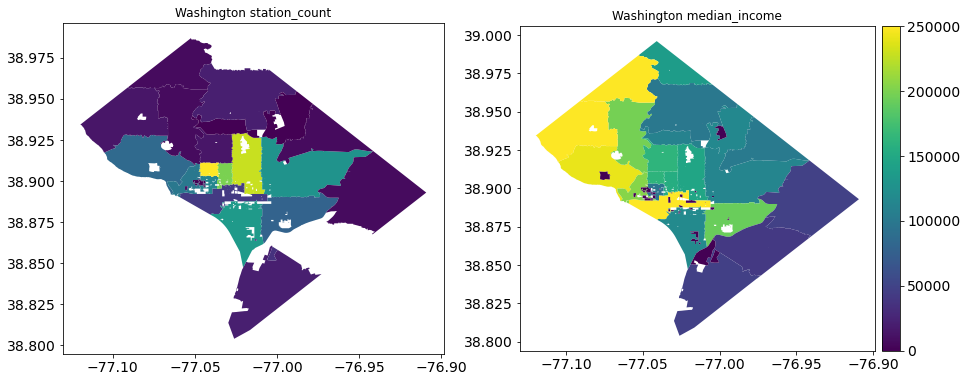

In [215]:
for city in cities:
    plot_comparison_maps(EV_demo_geo[city], 'station_count', 'median_income', f'{city} station_count', 
                         f'{city} median_income')